In [9]:
pip install nba_api

In [29]:
import random
import logging
import pandas as pd
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats

# Configure logging to show info and warnings in the console with timestamps
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger()

def extract_start_year(season_id):
    """
    Extract the starting year (e.g., 1997 from '1997-98') from a SEASON_ID string.

    Args:
        season_id (str): The season string in format 'YYYY-YY'.

    Returns:
        int or None: The integer start year if extraction is successful, otherwise None.
    """
    try:
        year_str = season_id[:4]
        return int(year_str)
    except Exception as e:
        logger.warning(f"Could not parse season year from SEASON_ID: {season_id}. Error: {str(e)}")
        return None

def get_players_sample_by_decade(all_players, start_year, end_year, sample_size=150, max_players=50):
    """
    Randomly samples a subset of players and filters those who began their careers within a specific decade.

    Args:
        all_players (list): List of player dictionaries from nba_api.
        start_year (int): Start of the decade (e.g., 1980).
        end_year (int): End of the decade (e.g., 1989).
        sample_size (int): How many players to sample from the total list.
        max_players (int): Max number of valid players to return for the decade.

    Returns:
        list: List of player dictionaries that started their careers in the given decade.
    """
    logger.info(f"Sampling players for decade {start_year}-{end_year}")
    sampled = random.sample(all_players, min(sample_size, len(all_players)))  # Ensure we don’t exceed available players
    selected_players = []

    for p in sampled:
        try:
            # Fetch career data for the player
            career = playercareerstats.PlayerCareerStats(player_id=p['id'])
            df_career = career.get_data_frames()[0]

            if not df_career.empty:
                first_season_id = df_career['SEASON_ID'].iloc[0]
                first_year = extract_start_year(first_season_id)

                if first_year and start_year <= first_year <= end_year:
                    selected_players.append(p)
                    logger.info(f"Selected player: {p['full_name']} (First year: {first_year})")

                    if len(selected_players) >= max_players:
                        logger.info(f"Reached max players ({max_players}) for {start_year}-{end_year}")
                        break
        except Exception as e:
            logger.warning(f"Error fetching career for {p['full_name']}: {str(e)}")

    logger.info(f"Total players selected for {start_year}-{end_year}: {len(selected_players)}")
    return selected_players

def fetch_stats_for_players(player_list, decade):
    """
    Retrieve full career stats for a given list of players and label them with the appropriate decade.

    Args:
        player_list (list): List of players (dicts) to fetch stats for.
        decade (int): The start year of the decade (used for labeling).

    Returns:
        DataFrame: A pandas DataFrame of all player stats with decade and player name columns added.
    """
    logger.info(f"Fetching stats for {len(player_list)} players in {decade}s decade")
    all_stats = []

    for player in player_list:
        try:
            # Retrieve career stats
            career = playercareerstats.PlayerCareerStats(player_id=player['id'])
            df = career.get_data_frames()[0]

            if not df.empty:
                df['Player'] = player['full_name']
                all_stats.append(df)
                logger.info(f"Fetched stats for {player['full_name']}")
            else:
                logger.warning(f"No stats data for {player['full_name']}")
        except Exception as e:
            logger.warning(f"Error fetching stats for {player['full_name']}: {str(e)}")

    # Combine all player data into a single DataFrame
    combined_df = pd.concat(all_stats, ignore_index=True) if all_stats else pd.DataFrame()
    logger.info(f"Combined dataframe shape for {decade}s: {combined_df.shape}")
    return combined_df

def main():
    """
    Main workflow to collect NBA player stats grouped by decade from the 1970s to 2020s.
    Saves the final merged dataset to a CSV file.
    """
    # Get metadata for all known NBA players
    all_players = players.get_players()
    logger.info(f"Total players available: {len(all_players)}")

    # Define decades (including 2020s up to 2025)
    decades = [(year, year + 9) for year in range(1970, 2020, 10)] + [(2020, 2025)]
    all_decade_dfs = []

    # Loop through each decade
    for start_year, end_year in decades:
        logger.info(f"Processing decade: {start_year}-{end_year}")

        # Step 1: Sample players from the decade
        players_in_decade = get_players_sample_by_decade(all_players, start_year, end_year)

        # Step 2: Get stats if players were found
        if players_in_decade:
            decade_df = fetch_stats_for_players(players_in_decade, start_year)
            if not decade_df.empty:
                # Tag the stats with the corresponding decade
                decade_df['Decade'] = f"{start_year}s"
                all_decade_dfs.append(decade_df)
                logger.info(f"Completed processing for {start_year}s decade")
            else:
                logger.warning(f"No stats data collected for {start_year}s decade")
        else:
            logger.warning(f"No players selected for {start_year}s decade")

    # Step 3: Combine all decades into one final dataset
    if all_decade_dfs:
        final_df = pd.concat(all_decade_dfs, ignore_index=True)
        logger.info(f"Final combined dataframe shape: {final_df.shape}")
        logger.info(f"Columns in final dataframe: {list(final_df.columns)}")

        # Preview the dataset
        logger.info("Preview of the first 5 rows of the final dataframe:")
        logger.info("\n" + final_df[['Player', 'Decade', 'SEASON_ID', 'TEAM_ABBREVIATION', 'PTS', 'REB', 'AST']].head().to_string(index=False))

        # Save to disk
        final_df.to_csv('nba_players_by_decade.csv', index=False)
        logger.info("Saved final dataframe to 'nba_players_by_decade.csv'")
    else:
        logger.error("No data collected for any decade")

# Run the script
if __name__ == "__main__":
    main()


<ipython-input-29-f453ab2b33a0>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_stats, ignore_index=True) if all_stats else pd.DataFrame()
<ipython-input-29-f453ab2b33a0>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_stats, ignore_index=True) if all_stats else pd.DataFrame()


In [42]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Read the uploaded CSV file
foreign_df = pd.read_csv(list(uploaded.keys())[0])

# Filter for foreign players (nationality is not United States)
foreign_players = foreign_df[foreign_df['nationality'] != 'United States']

# Display the first few rows of the filtered dataset
print(foreign_players.head())

Saving players_stats_by_season_full_details.csv to players_stats_by_season_full_details (2).csv
   League       Season           Stage           Player Team  GP     MIN  FGM  \
30    NBA  1999 - 2000  Regular_Season    Dirk Nowitzki  DAL  82  2938.0  515   
60    NBA  1999 - 2000  Regular_Season        Rik Smits  IND  79  1852.0  431   
65    NBA  1999 - 2000  Regular_Season      Vlade Divac  SAC  82  2374.0  384   
78    NBA  1999 - 2000  Regular_Season  Dikembe Mutombo  ATL  82  2984.0  322   
80    NBA  1999 - 2000  Regular_Season    Patrick Ewing  NYK  62  2035.0  361   

     FGA  3PM  ...    birth_date  height  height_cm  weight  weight_kg  \
30  1118  116  ...  Jun 19, 1978     7-0      213.0   245.0      111.0   
60   890    0  ...  Aug 23, 1966     7-4      224.0   250.0      113.0   
65   764    7  ...   Feb 3, 1968     7-1      216.0   260.0      118.0   
78   573    0  ...  Jun 25, 1966     7-2      218.0   260.0      118.0   
80   775    0  ...   Aug 5, 1962     7-0      2

In [30]:
import pandas as pd

# Load the CSV saved earlier (assuming the file exists)
df = pd.read_csv('nba_players_by_decade.csv')

# Preview the top 10 rows with selected columns
df[['Player', 'Decade', 'SEASON_ID', 'TEAM_ABBREVIATION', 'PTS', 'REB', 'AST']].head(10)


,Player,Decade,SEASON_ID,TEAM_ABBREVIATION,PTS,REB,AST
0,Ted Manakas,1970s,1973-74,KCK,12,3,2
1,Garfield Smith,1970s,1970-71,BOS,106,95,9
2,Garfield Smith,1970s,1971-72,BOS,62,37,8
3,Leon Benbow,1970s,1974-75,CHI,85,38,25
4,Leon Benbow,1970s,1975-76,CHI,543,176,158
5,John Brown,1970s,1973-74,ATL,717,441,114
6,John Brown,1970s,1974-75,ATL,815,434,133
7,John Brown,1970s,1975-76,ATL,592,403,126
8,John Brown,1970s,1976-77,ATL,441,236,103
9,John Brown,1970s,1977-78,ATL,549,303,105


<ipython-input-31-10ea30729d50>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')


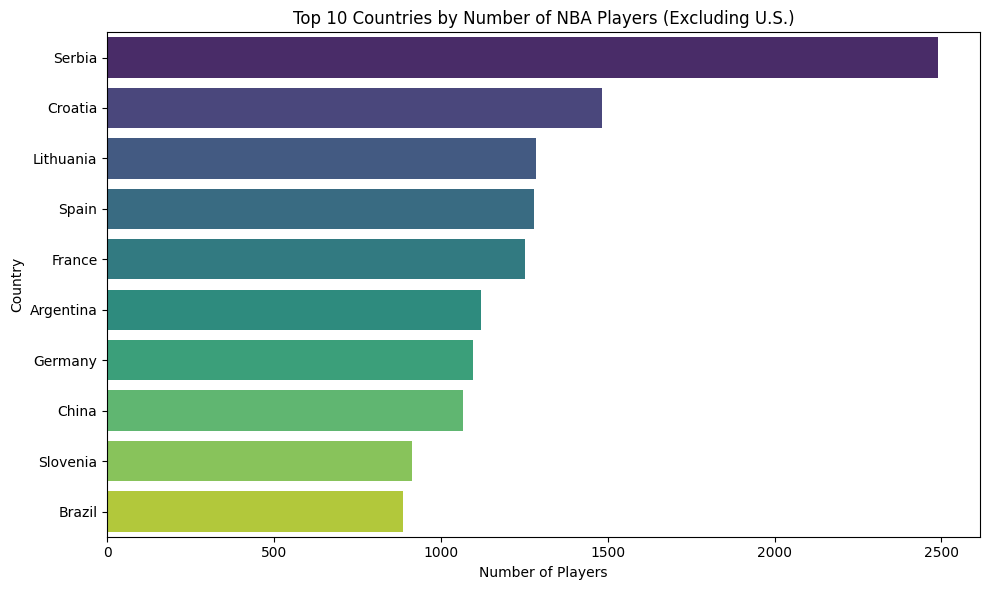

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

top_countries = foreign_players['nationality'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title("Top 10 Countries by Number of NBA Players (Excluding U.S.)")
plt.xlabel("Number of Players")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


<ipython-input-32-a29c53daa61a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_pts_by_country.values, y=avg_pts_by_country.index, palette='coolwarm')


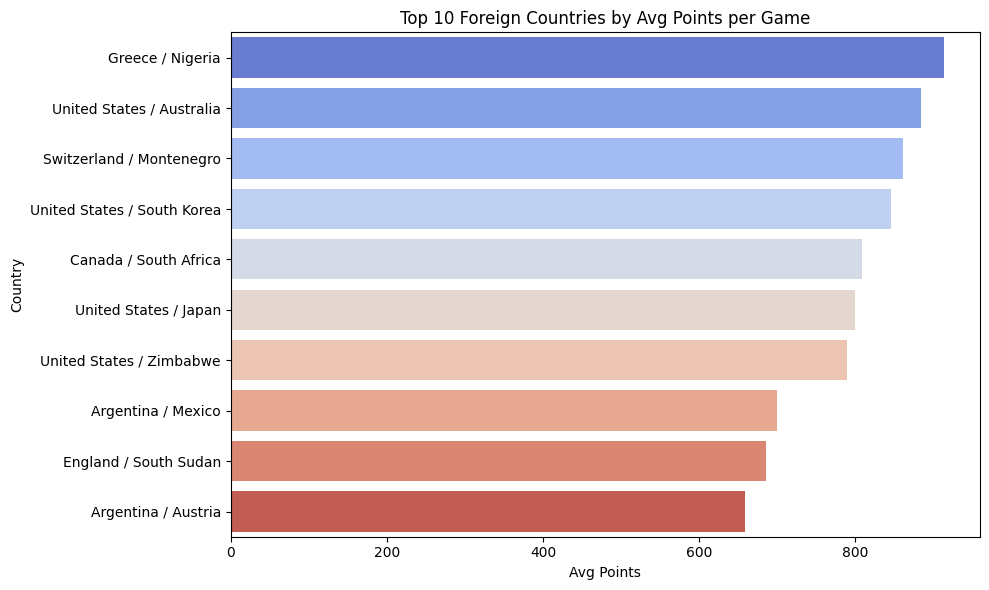

In [32]:
avg_pts_by_country = foreign_players.groupby('nationality')['PTS'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_pts_by_country.values, y=avg_pts_by_country.index, palette='coolwarm')
plt.title("Top 10 Foreign Countries by Avg Points per Game")
plt.xlabel("Avg Points")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


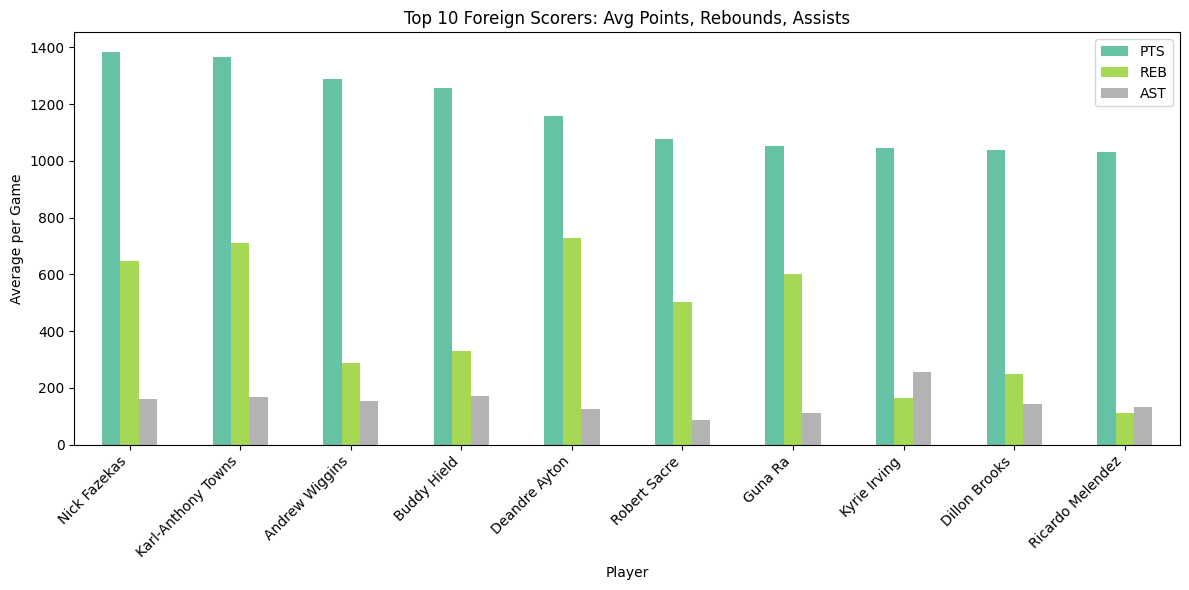

In [34]:
top_foreign_scorers = foreign_players.groupby('Player')[['PTS', 'REB', 'AST']].mean().sort_values('PTS', ascending=False).head(10)

top_foreign_scorers.plot(kind='bar', figsize=(12,6), colormap='Set2')
plt.title("Top 10 Foreign Scorers: Avg Points, Rebounds, Assists")
plt.ylabel("Average per Game")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [36]:
import pandas as pd

# Load both datasets
foreign_df = pd.read_csv('foreign_players_stats.csv')  # Your second dataset
decade_df = pd.read_csv('nba_players_by_decade.csv')   # Your first dataset

# Harmonize player name column
foreign_df.rename(columns={'Player': 'Player'}, inplace=True)  # Already named correctly
decade_df.rename(columns={'Player': 'Player'}, inplace=True)   # Already named correctly

# Convert relevant columns to numeric (may be needed if they were read as strings)
for col in ['PTS', 'REB', 'AST']:
    decade_df[col] = pd.to_numeric(decade_df[col], errors='coerce')
    foreign_df[col] = pd.to_numeric(foreign_df[col], errors='coerce')

# --- Compute per-player averages ---
# Decade group: U.S. + Foreign
decade_avg = decade_df.groupby('Player')[['PTS', 'REB', 'AST']].mean().reset_index()
decade_avg['Group'] = 'Random Sample by Decade'

# Foreign player group
foreign_avg = foreign_df.groupby('Player')[['PTS', 'REB', 'AST']].mean().reset_index()
foreign_avg['Group'] = 'Foreign Players'

# --- Combine the two for comparison ---
combined_df = pd.concat([decade_avg, foreign_avg], ignore_index=True)

# --- Compare Group-Level Averages ---
group_stats = combined_df.groupby('Group')[['PTS', 'REB', 'AST']].mean().round(2)
print("Average Season Stats Comparison:\n", group_stats)

# Optional: Save to CSV
combined_df.to_csv("foreign_vs_decade_players_avg.csv", index=False)
group_stats.to_csv("group_comparison_summary.csv")



Average Season Stats Comparison:
                             PTS     REB    AST
Group                                         
Foreign Players          213.24   91.11  42.92
Random Sample by Decade  286.77  124.01  61.55


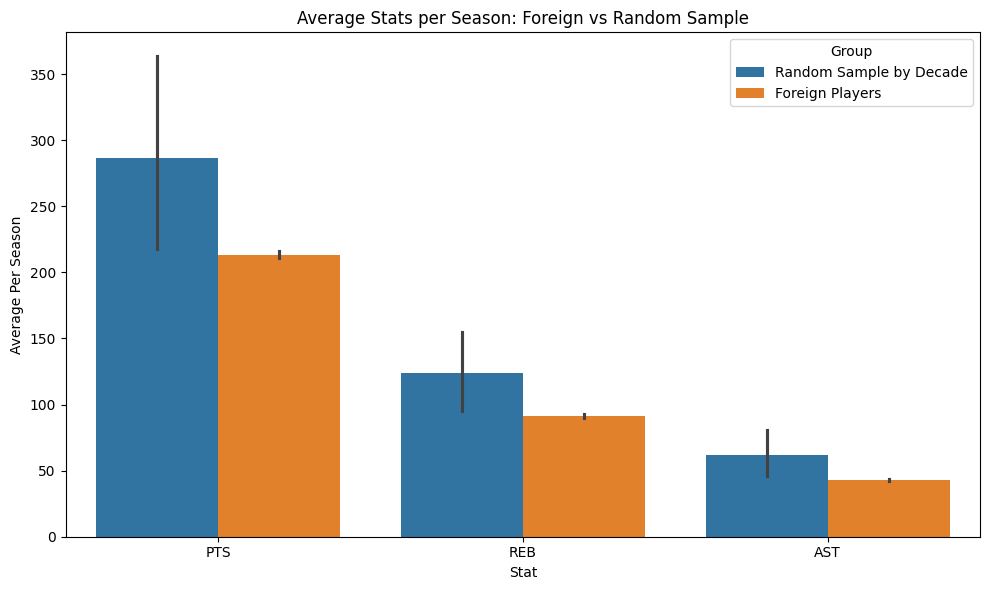

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

melted = combined_df.melt(id_vars='Group', value_vars=['PTS', 'REB', 'AST'],
                          var_name='Stat', value_name='Average')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Stat', y='Average', hue='Group')
plt.title('Average Stats per Season: Foreign vs Random Sample')
plt.ylabel('Average Per Season')
plt.tight_layout()
plt.show()


In [43]:
# Normalize player names
foreign_names = set(foreign_df['Player'].str.lower().str.strip())
decade_names = set(df['Player'].str.lower().str.strip())

# Overlap
foreign_in_decades = foreign_names.intersection(decade_names)

print(f"Total foreign players in dataset 2: {len(foreign_names)}")
print(f"Total players in decade dataset: {len(decade_names)}")
print(f"Foreign players also in decade dataset: {len(foreign_in_decades)}")
print("Examples:", list(foreign_in_decades)[:10])



Total foreign players in dataset 2: 14582
Total players in decade dataset: 83
Foreign players also in decade dataset: 32
Examples: ['mike batiste', 'jerome robinson', 'jaylen morris', 'jameer nelson', 'jamaal magloire', 'cheick diallo', 'sergei monia', 'derrick alston', 'john brown', 'david rivers']


In [44]:
# Group by Decade
avg_by_decade = df.groupby('Decade')[['PTS', 'REB', 'AST']].mean().round(2)

print("Average performance by decade:")
print(avg_by_decade)


Average performance by decade:
           PTS     REB     AST
Decade                        
1970s   414.52  165.50   97.32
1980s   530.07  170.70  107.64
1990s   370.90  107.81  126.77
2000s   424.13  225.99   87.58
2010s   476.19  226.37   97.19
2020s   394.53  164.12  118.76


In [45]:
# Filter foreign players from df
foreign_subset = df[df['Player'].str.lower().isin(foreign_names)]

# Calculate means
overall_mean = df[['PTS', 'REB', 'AST']].mean().round(2)
foreign_mean = foreign_subset[['PTS', 'REB', 'AST']].mean().round(2)

comparison_df = pd.DataFrame({
    'Overall (All Players)': overall_mean,
    'Foreign Players Only': foreign_mean
})

print("Average season stats comparison:")
print(comparison_df)


Average season stats comparison:
     Overall (All Players)  Foreign Players Only
PTS                 451.01                536.20
REB                 188.59                245.45
AST                 102.54                129.73


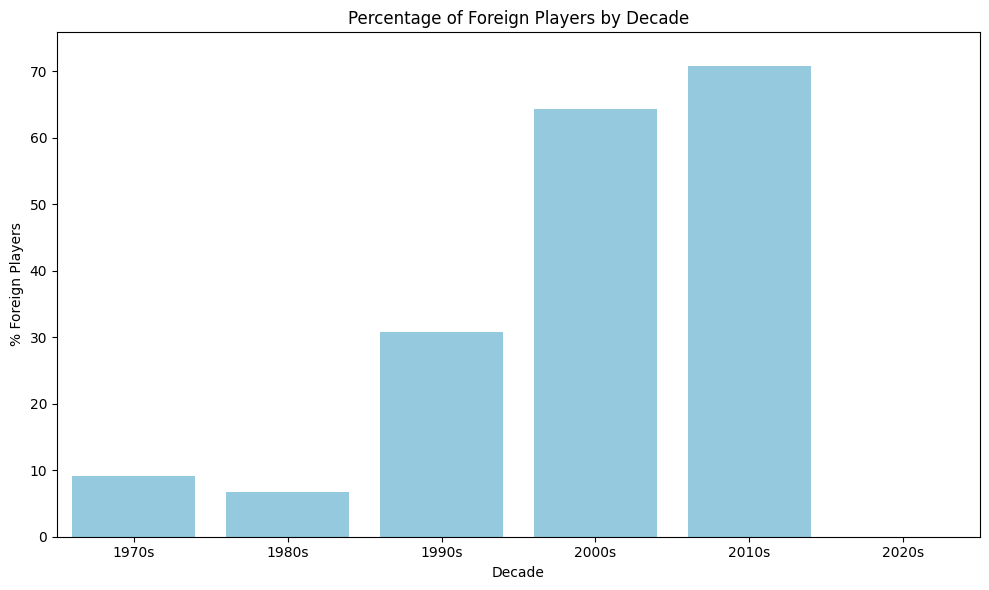

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count foreign players in each decade
foreign_subset = df[df['Player'].str.lower().isin(foreign_names)]
foreign_by_decade = foreign_subset.groupby('Decade')['Player'].nunique()
total_by_decade = df.groupby('Decade')['Player'].nunique()

# Combine for comparison
decade_summary = pd.DataFrame({
    'Foreign Players': foreign_by_decade,
    'Total Players': total_by_decade
})
decade_summary['% Foreign'] = (decade_summary['Foreign Players'] / decade_summary['Total Players'] * 100).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=decade_summary.index, y=decade_summary['% Foreign'], color='skyblue')
plt.title('Percentage of Foreign Players by Decade')
plt.ylabel('% Foreign Players')
plt.xlabel('Decade')
plt.ylim(0, decade_summary['% Foreign'].max() + 5)
plt.tight_layout()
plt.show()



<ipython-input-49-19a0e2f789e8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Is_Foreign', y='PTS', palette='pastel')


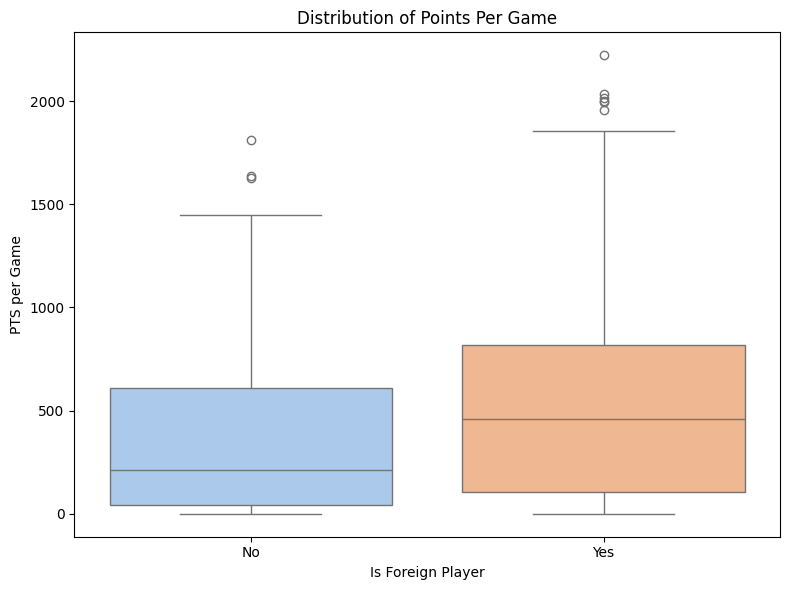

In [49]:
# Tag foreign players
df['Is_Foreign'] = df['Player'].str.lower().isin(foreign_names)

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Is_Foreign', y='PTS', palette='pastel')
plt.title('Distribution of Points Per Game')
plt.xlabel('Is Foreign Player')
plt.ylabel('PTS per Game')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()


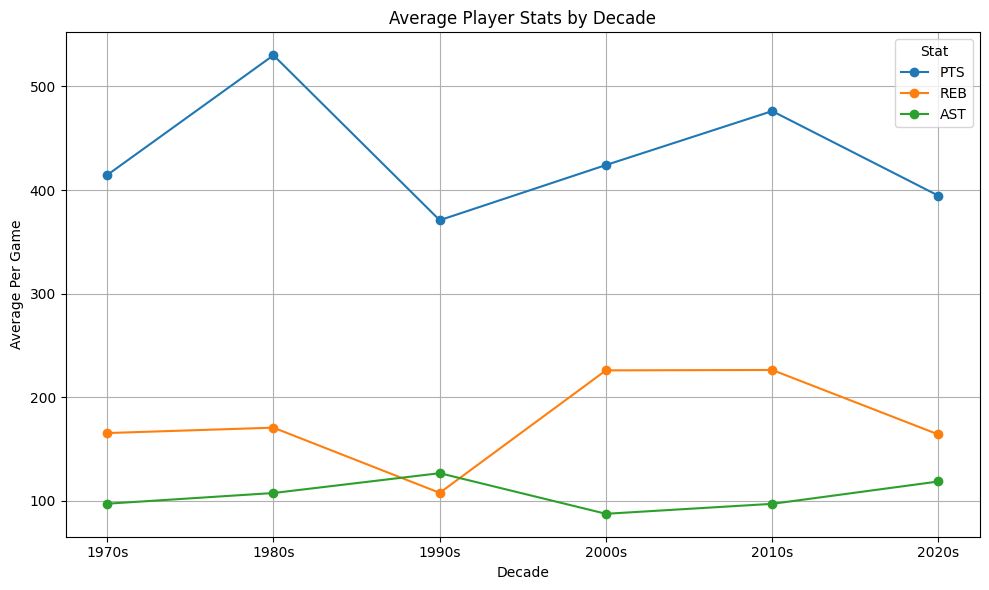

In [50]:
# Group by Decade and compute mean stats
decade_stats = df.groupby('Decade')[['PTS', 'REB', 'AST']].mean().round(2)

# Plot
decade_stats.plot(marker='o', figsize=(10, 6))
plt.title('Average Player Stats by Decade')
plt.ylabel('Average Per Game')
plt.xlabel('Decade')
plt.grid(True)
plt.legend(title='Stat')
plt.tight_layout()
plt.show()


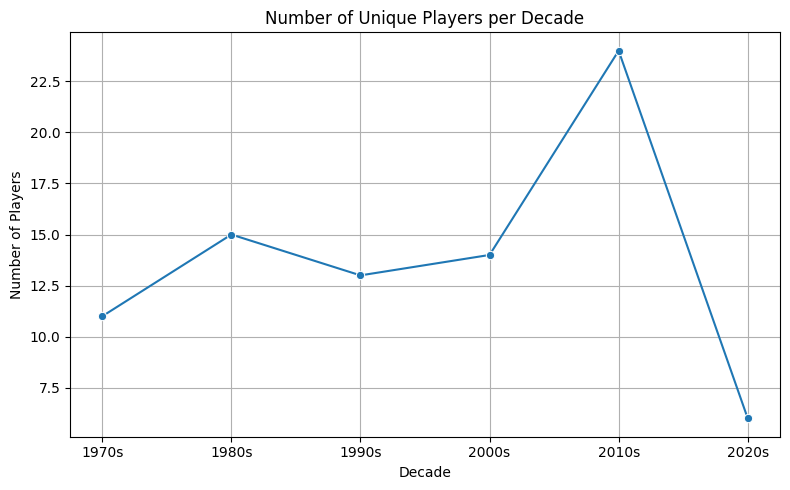

In [51]:
player_counts = df.groupby('Decade')['Player'].nunique()

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=player_counts.index, y=player_counts.values, marker='o')
plt.title('Number of Unique Players per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Players')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-53-c141c43752d9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Decade', y='PTS', data=df, palette='coolwarm')


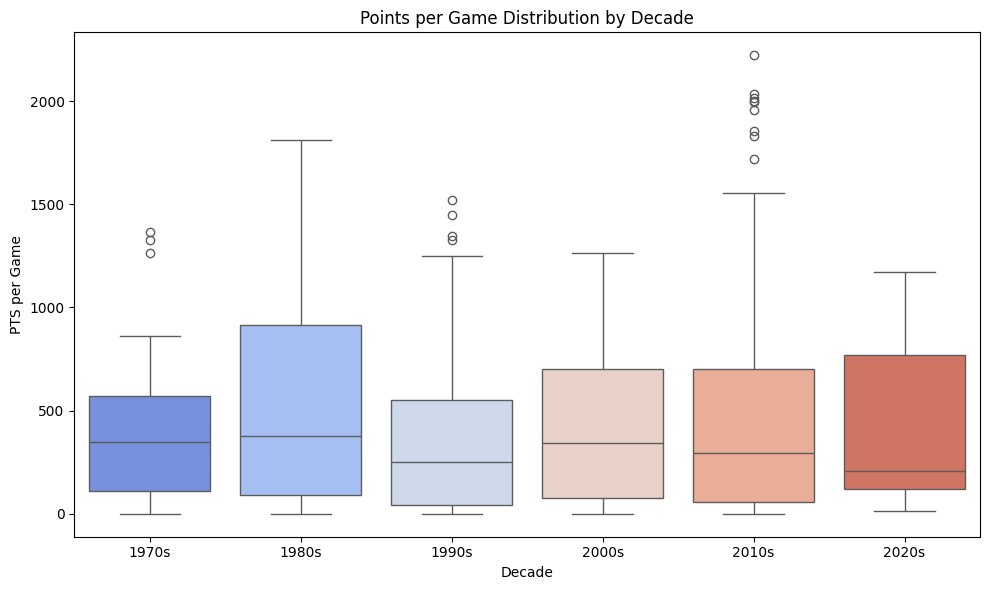

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Decade', y='PTS', data=df, palette='coolwarm')
plt.title('Points per Game Distribution by Decade')
plt.ylabel('PTS per Game')
plt.xlabel('Decade')
plt.tight_layout()
plt.show()
